In [37]:
using PlotlyJS
using Parquet2: writefile, Dataset

include("./utils.jl")
include("./unit_commitment.jl")
include("./plotting.jl")
include("./economic_dispatch.jl")
include("./processing.jl")
mip_gap = 0.0001

0.0001

In [38]:
gen_info, fuels, loads, gen_variable_info, storage_info = read_data()
gen_df = pre_process_generators_data(gen_info, fuels)
gen_variable = pre_process_gen_variable(gen_df, gen_variable_info)
storage_df = pre_process_storage_data(storage_info)
random_loads_df = read_random_demand()

# A spring day
n = div(5363, 24)
# n=100
T_period = (n*24+1):((n+1)*24)


# Small storage
storage_df.existing_cap_mw .= 0.8*storage_df.existing_cap_mw
storage_df.max_energy_mwh .= 0.8*storage_df.max_energy_mwh

# Filtering data with timeseries according to T_period
gen_variable_multi = gen_variable[in.(gen_variable.hour,Ref(T_period)),:];
loads_multi = loads[in.(loads.hour,Ref(T_period)),:]
random_loads_multi =  random_loads_df[in.(random_loads_df.hour,Ref(T_period)),:];

required_reserve, required_energy_reserve, required_energy_reserve_cumulated = generate_reserves(loads_multi, 0.1, 0)
configs = generate_configurations(required_energy_reserve, required_energy_reserve_cumulated)
;

In [39]:
max_iterations = 1000
configs = Dict(k => merge(v,(max_iterations = max_iterations,)) for (k,v) in configs)

Dict{Symbol, NamedTuple} with 9 entries:
  :base_ramp_storage        => (ramp_constraints = true, storage = 10×19 DataFr…
  :base_ramp_storage_envel… => (ramp_constraints = true, storage = 10×19 DataFr…
  :base_ramp_reserve        => (ramp_constraints = true, reserve = 24×3 DataFra…
  :base_ramp_storage_energ… => (ramp_constraints = true, storage = 10×19 DataFr…
  :base_ramp_storage_reser… => (ramp_constraints = true, storage = 10×19 DataFr…
  :base_ramp_energy_reserve => (ramp_constraints = true, energy_reserve = 300×4…
  :base                     => (ramp_constraints = false, enriched_solution = t…
  :base_ramp_storage_energ… => (ramp_constraints = true, storage = 10×19 DataFr…
  :base_ramp                => (ramp_constraints = true, enriched_solution = tr…

In [40]:
include("./economic_dispatch.jl")
s_uc = Dict()
s_ed = Dict()
subset = [:base_ramp_storage_reserve, :base_ramp_storage_envelopes, :base_ramp_storage_energy_reserve_cumulated]
for k in intersect(keys(configs), subset)
    s_uc[k] = solve_unit_commitment(
        gen_df,
        loads_multi,
        gen_variable_multi,
        mip_gap;
        configs[k]...
    )
    s_ed[k] = solve_economic_dispatch(
        gen_df,
        random_loads_multi,
        gen_variable_multi,
        mip_gap;
        configs[k]...
    )
end
s_ed = merge_solutions(s_ed, :configuration)
s_uc =  merge_solutions(s_uc, :configuration)

s_uc = Dict(pairs(s_uc))
s_uc[:reserve] = vcat(s_uc[:reserve], s_uc[:energy_reserve][s_uc[:energy_reserve].hour.==s_uc[:energy_reserve].hour_i,:][:,Not(:hour_i)])
s_uc = NamedTuple(s_uc)
;



In [41]:
# using Parquet2: writefile, Dataset
write = false
read = false
if write
    using Parquet2: writefile, Dataset
    writefile("./output/s_uc.parq", s_uc)
    writefile("./output/s_ed.parq", s_ed)
end
if read
    s_uc = DataFrame(Dataset("./output/s_uc.parq"); copycols=false)
    s_ed = DataFrame(Dataset("./output/s_ed.parq"); copycols=false)  
end


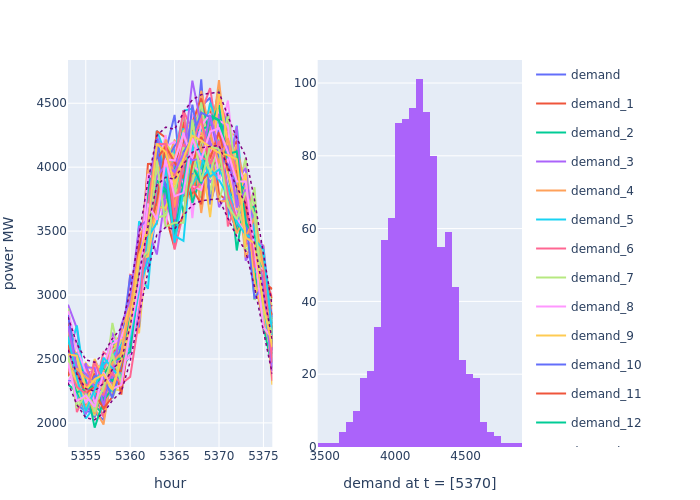

In [42]:
select_first = 100
to_plot_demand = stack(random_loads_multi[!,1:(select_first+1)], Not(:hour))
to_plot_reserve = copy(required_reserve)
to_plot_reserve.reserve_up_MW = required_reserve.reserve_up_MW .+ loads_multi.demand
to_plot_reserve.reserve_down_MW = -required_reserve.reserve_down_MW .+ loads_multi.demand
to_plot_reserve.demand_MW = loads_multi.demand
to_plot_reserve = stack(to_plot_reserve, Not(:hour))
s= scatter(to_plot_demand, x = :hour, y = :value, group = :variable)
s1 = scatter(to_plot_reserve, x = :hour, y = :value, group = :variable, line=attr(color="purple", width=1.5, dash="dot"))
union!(s,s1)
p1 = plot(s, Layout(yaxis_title="power MW", xaxis_title="hour"))

t_ = loads_multi[loads_multi.demand .== maximum(loads_multi.demand),:hour]
to_plot_histogram = stack(random_loads_multi[random_loads_multi.hour .== t_, :])
p2 = plot(to_plot_histogram, x = :value, kind="histogram", histonorm = "percent", Layout(xaxis_title_text="demand at t = $t_"))

[p1 p2]

In [43]:
thres =.1
f_LOL(x,y) = 
    (LOL_hours=count(x.>thres),
    LOLP=count(x.>thres)/count(y.>=thres)*100,
    LOL_MW = sum(x),
    LOL_percentage = sum(x)/sum(y)*100,
    Demand_MWh = sum(y),
    )
f_CUR(x,y) =     
    (CUR_hours=count(x.>thres*y.>thres),
    CURP=count(x.>thres)/count(y.>=0)*100,
    CUR_MW = sum(x),
    CUR_percentage = sum(x)/sum(y)*100,
    RES_generation_MWh = sum(y),
    )
    

f_CUR (generic function with 1 method)

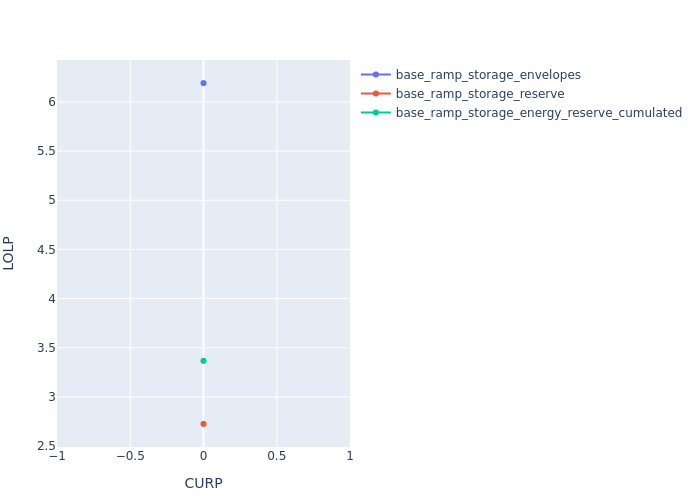

In [44]:
LOL = combine(groupby(s_ed.demand, [:configuration]), [:LOL_MW, :demand_MW] => ((x,y)->f_LOL(x,y)) => AsTable)
filter = in(["onshore_wind_turbine","small_hydroelectric","solar_photovoltaic"]).(s_ed.generation.resource)
CUR = combine(groupby(s_ed.generation[filter,:], [:configuration]), [:curtailment_MW, :production_MW] =>((x,y) -> f_CUR(x,y))=> AsTable)
LOL_CUR = outerjoin(LOL, CUR, on=[:configuration])
plot(LOL_CUR, x = :CURP, y = :LOLP, group = :configuration)

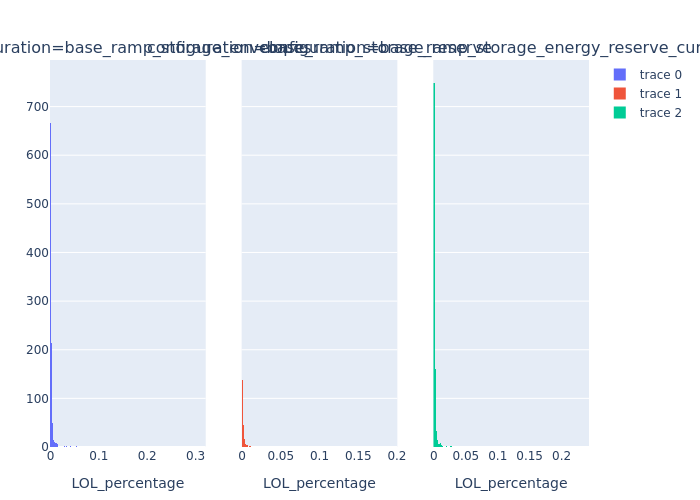

In [45]:

gdf_LOL = combine(groupby(s_ed.demand, [:iteration, :configuration]), [:LOL_MW, :demand_MW] => ((x,y)->f_LOL(x,y)) => AsTable)
plot(gdf_LOL, x = :LOL_percentage, kind="histogram", facet_col = :configuration, histonorm = "percent")

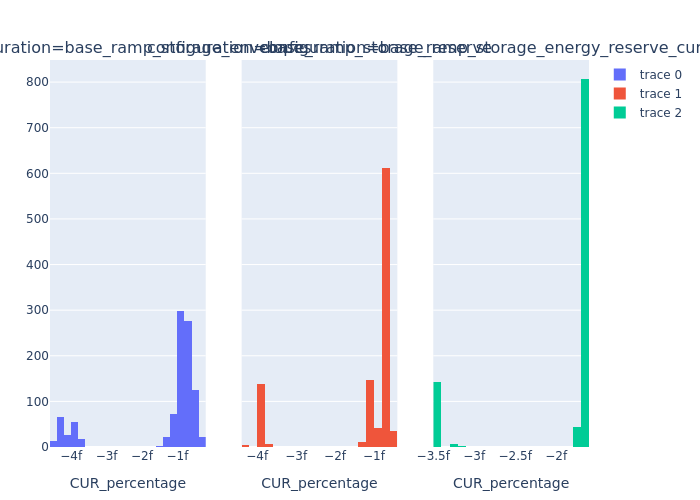

In [46]:
filter = in(["onshore_wind_turbine","small_hydroelectric","solar_photovoltaic"]).(s_ed.generation.resource) 
gdf_CUR = combine(groupby(s_ed.generation[filter,:], [:iteration, :configuration]), [:curtailment_MW, :production_MW] =>((x,y) -> f_CUR(x,y))=> AsTable)
plot(gdf_CUR, x = :CUR_percentage, kind="histogram", facet_col = :configuration, histonorm = "percent")

In [47]:
group_by = [:hour, :resource, :configuration]
supply_uc, demand_uc = calculate_supply_demand(s_uc, [:hour, :resource, :configuration])
supply_ed, demand_ed = calculate_supply_demand(s_ed, [:hour, :resource, :iteration, :configuration])
;

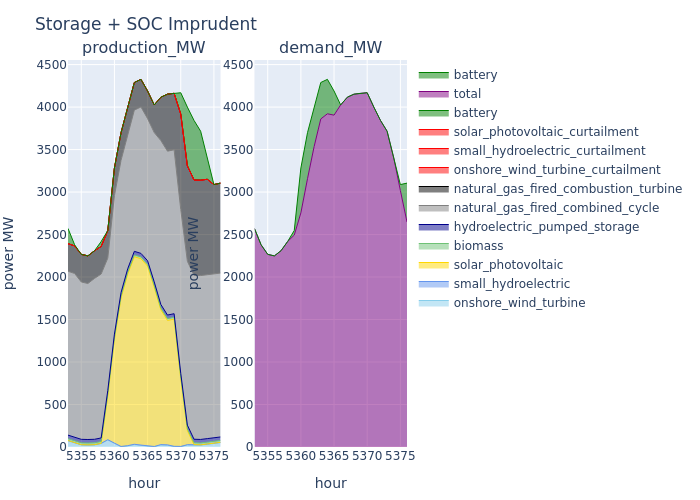

In [48]:
supply_ = supply_uc[supply_uc.configuration .== :base_ramp_storage_reserve, :]
demand_ = demand_uc[demand_uc.configuration .== :base_ramp_storage_reserve, :]
solution_reserve_ = s_uc.reserve[s_uc.reserve.configuration .== :base_ramp_storage_reserve, :]
reserve_ = calculate_reserve(solution_reserve_, required_reserve)
plot_supply_demand(supply_, demand_,"Storage + SOC Imprudent")

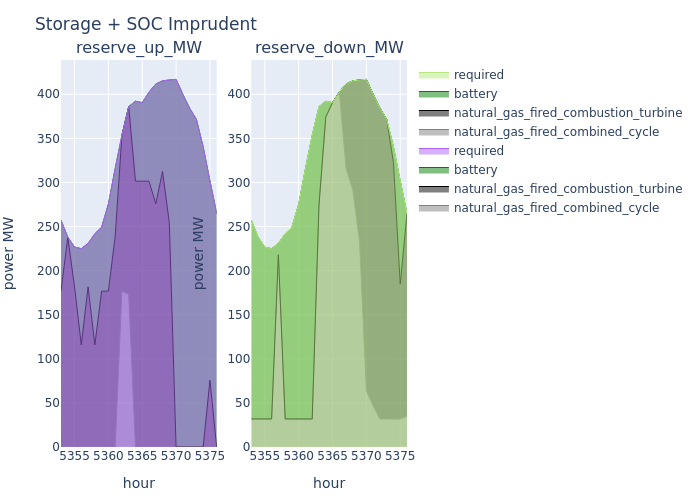

In [49]:
plot_reserve(reserve_, "Storage + SOC Imprudent")


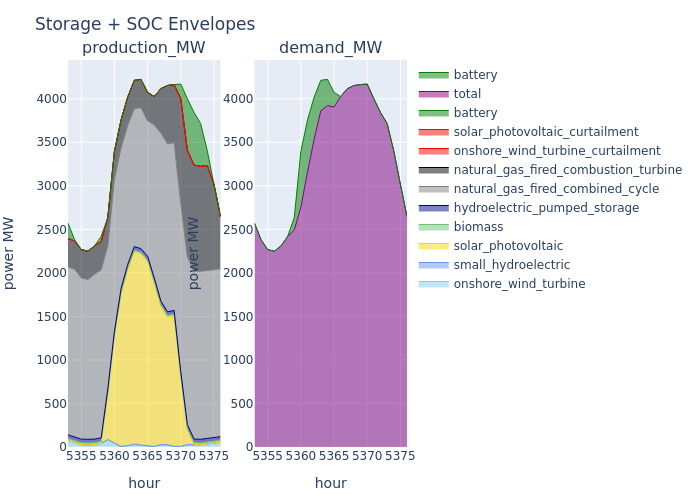

In [50]:
supply_ = supply_uc[supply_uc.configuration .== :base_ramp_storage_envelopes, :]
demand_ = demand_uc[demand_uc.configuration .== :base_ramp_storage_envelopes, :]
solution_reserve_ = s_uc.reserve[s_uc.reserve.configuration .== :base_ramp_storage_envelopes, :]
reserve_ = calculate_reserve(solution_reserve_, required_reserve)
plot_supply_demand(supply_, demand_,"Storage + SOC Envelopes")

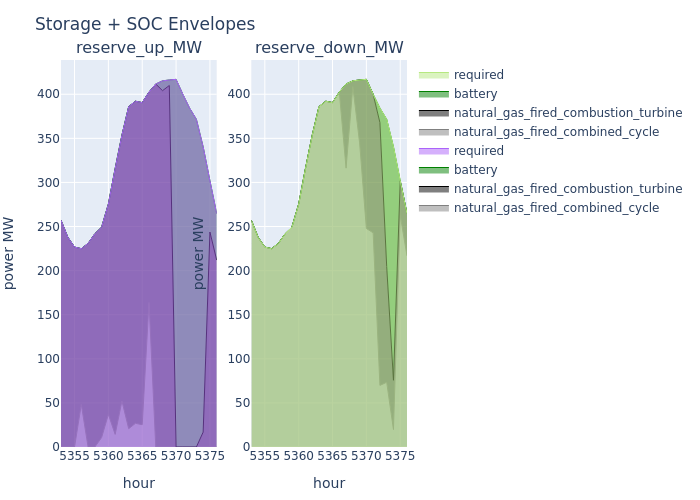

In [51]:
plot_reserve(reserve_, "Storage + SOC Envelopes")

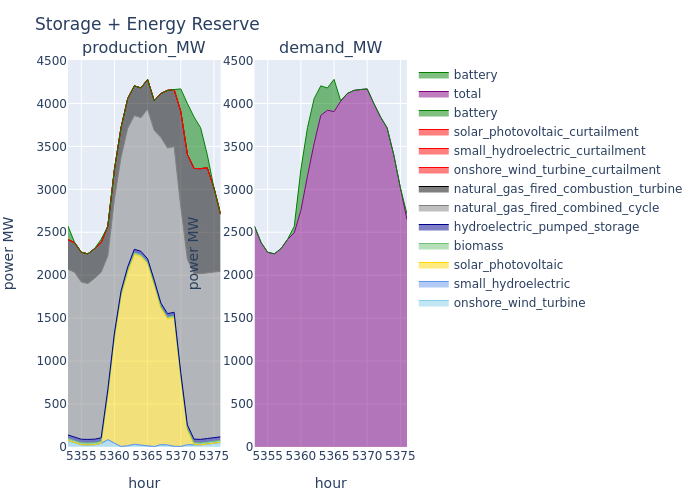

In [52]:
supply_ = supply_uc[supply_uc.configuration .== :base_ramp_storage_energy_reserve_cumulated, :]
demand_ = demand_uc[demand_uc.configuration .== :base_ramp_storage_energy_reserve_cumulated, :]
solution_reserve_ = s_uc.reserve[s_uc.reserve.configuration .== :base_ramp_storage_energy_reserve_cumulated, :]
reserve_ = calculate_reserve(solution_reserve_, required_reserve)
plot_supply_demand(supply_, demand_,"Storage + Energy Reserve")

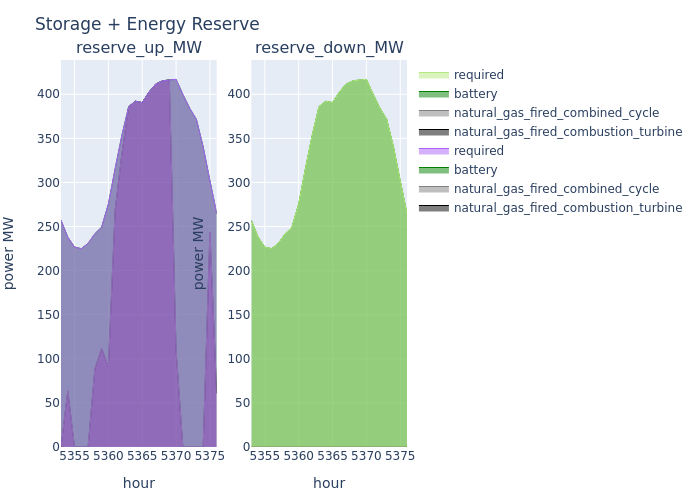

In [53]:
plot_reserve(reserve_, "Storage + Energy Reserve")